# Initialization

## Requirements

In [ ]:
%pip install scipy
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install neurodsp
%pip install specparam
%pip install EntropyHub
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Libraries & Modules

In [ ]:
import scipy
import os
import scipy.io
from scipy.io import loadmat
from scipy.stats import mode
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from scipy.signal import welch
from specparam import SpectralModel
from neurodsp.aperiodic import compute_fluctuations
from scipy.stats import zscore
from scipy.signal import savgol_filter
import EntropyHub as EH
from EntropyHub import MSEn, MSobject
import sys
from neurodsp.aperiodic import compute_fluctuations
from scipy.signal import savgol_filter
import seaborn as sns

#Local Modules
from dataset_loader.loader import DatasetLoader
from dataset_loader.helper import get_metadata

## Loader

In [ ]:
local_path = r'D:\Projects\Donders Project\table\table_creation_for_complexity_analysis'
sys.path.append(local_path)  # path to dataset loader


CONFIG_PATH = os.path.join(local_path, 'configs/configcbd.yaml')

loader = DatasetLoader(CONFIG_PATH)
dataset_map = loader.load_datasets()


df1 = pd.DataFrame([
    {
        'Name': key,
        'StatesFile': val[0],
        'HPCFile': val[1],
        'PFCFile': val[2]
    }
    for key, val in dataset_map.items()
])

df1


,Name,StatesFile,HPCFile,PFCFile
0,Rat3_SD16_OR_1_posttrial1,D:\Projects\Donders Project\Dataset\CBD\3\Rat_...,D:\Projects\Donders Project\Dataset\CBD\3\Rat_...,D:\Projects\Donders Project\Dataset\CBD\3\Rat_...
1,Rat3_SD16_OR_1_posttrial2,D:\Projects\Donders Project\Dataset\CBD\3\Rat_...,D:\Projects\Donders Project\Dataset\CBD\3\Rat_...,D:\Projects\Donders Project\Dataset\CBD\3\Rat_...
2,Rat3_SD16_OR_1_posttrial3,D:\Projects\Donders Project\Dataset\CBD\3\Rat_...,D:\Projects\Donders Project\Dataset\CBD\3\Rat_...,D:\Projects\Donders Project\Dataset\CBD\3\Rat_...
3,Rat3_SD16_OR_1_posttrial4,D:\Projects\Donders Project\Dataset\CBD\3\Rat_...,D:\Projects\Donders Project\Dataset\CBD\3\Rat_...,D:\Projects\Donders Project\Dataset\CBD\3\Rat_...
4,Rat3_SD16_OR_1_posttrial5,D:\Projects\Donders Project\Dataset\CBD\3\Rat_...,D:\Projects\Donders Project\Dataset\CBD\3\Rat_...,D:\Projects\Donders Project\Dataset\CBD\3\Rat_...
...,...,...,...,...
210,Rat6_SD8_HC_1_posttrial1,D:\Projects\Donders Project\Dataset\CBD\6\Rat_...,D:\Projects\Donders Project\Dataset\CBD\6\Rat_...,D:\Projects\Donders Project\Dataset\CBD\6\Rat_...
211,Rat6_SD8_HC_1_posttrial2,D:\Projects\Donders Project\Dataset\CBD\6\Rat_...,D:\Projects\Donders Project\Dataset\CBD\6\Rat_...,D:\Projects\Donders Project\Dataset\CBD\6\Rat_...
212,Rat6_SD8_HC_1_posttrial3,D:\Projects\Donders Project\Dataset\CBD\6\Rat_...,D:\Projects\Donders Project\Dataset\CBD\6\Rat_...,D:\Projects\Donders Project\Dataset\CBD\6\Rat_...
213,Rat6_SD8_HC_1_posttrial4,D:\Projects\Donders Project\Dataset\CBD\6\Rat_...,D:\Projects\Donders Project\Dataset\CBD\6\Rat_...,D:\Projects\Donders Project\Dataset\CBD\6\Rat_...


# Table Creation

## Metadata + Sleep State Extraction

In [ ]:
state_map = {1: 'Wake', 3: 'NREM', 4: 'TS', 5: 'REM'}

def extract_sleep_states(mat_path):

    state_map = {1: 'Wake', 3: 'NREM', 4: 'TS', 5: 'REM'}

    try:
        mat = scipy.io.loadmat(mat_path)
        for key in mat:
            if not key.startswith('__'):
                data = mat[key].squeeze()
                if isinstance(data, (np.ndarray, list)) and data.size > 0:
                    return [state_map[int(s)] for s in data if int(s) in state_map]
    except Exception as e:
        print(f"Error in {mat_path}: {e}")
    return []


rows = []

for name, (states_file, hpc_file, pfc_file) in dataset_map.items():
    try:
        meta = get_metadata(name)
        sleep_states = extract_sleep_states(states_file)

        for idx, state in enumerate(sleep_states):
            epoch_id = idx % 4  # Cycle: 0, 1, 2, 3, 0, 1, ...
            rows.append({
                'Name': name,
                'RatID': meta['rat_id'],
                'StudyDay': meta['study_day'],
                'Condition': meta['condition'],
                'Treatment': meta['treatment'],
                'Trial': meta['trial_num'],
                'EpochID': epoch_id,
                'State': state
            })

    except Exception as e:
        print(f"Failed to process {name}: {e}")

df = pd.DataFrame(rows)
df

,Name,RatID,StudyDay,Condition,Treatment,Trial,EpochID,State
0,Rat3_SD16_OR_1_posttrial1,3,16,OR,1,1,0,Wake
1,Rat3_SD16_OR_1_posttrial1,3,16,OR,1,1,1,Wake
2,Rat3_SD16_OR_1_posttrial1,3,16,OR,1,1,2,Wake
3,Rat3_SD16_OR_1_posttrial1,3,16,OR,1,1,3,Wake
4,Rat3_SD16_OR_1_posttrial1,3,16,OR,1,1,0,Wake
...,...,...,...,...,...,...,...,...
900946,Rat6_SD8_HC_1_posttrial5,6,8,HC,1,5,1,Wake
900947,Rat6_SD8_HC_1_posttrial5,6,8,HC,1,5,2,Wake
900948,Rat6_SD8_HC_1_posttrial5,6,8,HC,1,5,3,Wake
900949,Rat6_SD8_HC_1_posttrial5,6,8,HC,1,5,0,Wake


In [5]:
def read_mat_signal(mat_path, key_hint='PFC'):
    """
    Load signal from a .mat file based on key_hint ('PFC' or 'HPC').
    """
    mat = loadmat(mat_path)
    for key in mat:
        if not key.startswith('__') and key_hint.lower() in key.lower():
            signal = mat[key].squeeze()
            return signal
    raise ValueError(f"No matching signal found for key hint '{key_hint}' in {mat_path}")

## Aperiodic Fit

In [6]:
def extract_aperiodic_features(signal, fs=2500, epoch_len=4):
    window_size = epoch_len * fs
    num_windows = len(signal) // window_size
    exponents = []

    for i in range(num_windows):
        start, end = i * window_size, (i + 1) * window_size
        window_data = signal[start:end]
        freqs, psd = welch(window_data, fs=fs, nperseg=1024)
        mask = freqs <= 100
        freqs, psd = freqs[mask], psd[mask]

        fm = SpectralModel(min_peak_height=0.05, aperiodic_mode='knee', verbose=False)
        try:
            fm.fit(freqs, psd)
            exponent = fm.get_params('aperiodic')[1]
        except Exception:
            exponent = np.nan  # In case fitting fails
        exponents.append(exponent)

    exponents = np.array(exponents)

    # Threshold to remove outliers
    valid = ~np.isnan(exponents)
    exponents = exponents[valid]
    if len(exponents) == 0:
        return []

    threshold_min = np.percentile(exponents, 2)
    threshold_max = np.percentile(exponents, 98)
    valid_indices = (exponents >= threshold_min) & (exponents <= threshold_max)

    filtered_exponents = exponents[valid_indices]

    # Savgol fiter and normalization (-1, 1)
    window_length = 11 if len(filtered_exponents) >= 11 else len(filtered_exponents) | 1
    polyorder = 4
    smoothed = savgol_filter(filtered_exponents, window_length=window_length, polyorder=polyorder)

    normalized = 2 * ((smoothed - np.min(smoothed)) / (np.max(smoothed) - np.min(smoothed))) - 1

    full_normalized = np.full(num_windows, np.nan)
    valid_idx = np.where(valid)[0][valid_indices]
    full_normalized[valid_idx] = normalized

    return full_normalized

In [7]:
'''
rows = []

for name, (states_file, hpc_file, pfc_file) in dataset_map.items():
    try:
        meta = get_metadata(name)
        sleep_states = extract_sleep_states(states_file)
        pfc_signal = read_mat_signal(pfc_file, key_hint='PFC')

        aperiodic = extract_aperiodic_features(pfc_signal)

        min_len = min(len(sleep_states), len(aperiodic))
        for i in range(min_len):
            rows.append({
                'Name': name,
                'RatID': meta['rat_id'],
                'StudyDay': meta['study_day'],
                'Condition': meta['condition'],
                'Treatment': meta['treatment'],
                'Trial': meta['trial_num'],
                'EpochID': i % 4,
                'Sleep State': sleep_states[i],
                'AperiodicExponent': aperiodic[i]
            })
    except Exception as e:
        print(f"Error processing {name}: {e}")

df = pd.DataFrame(rows)
df.head()
'''

'\nrows = []\n\nfor name, (states_file, hpc_file, pfc_file) in dataset_map.items():\n    try:\n        meta = get_metadata(name)\n        sleep_states = extract_sleep_states(states_file)\n        pfc_signal = read_mat_signal(pfc_file, key_hint=\'PFC\')\n\n        aperiodic = extract_aperiodic_features(pfc_signal)\n\n        min_len = min(len(sleep_states), len(aperiodic))\n        for i in range(min_len):\n            rows.append({\n                \'Name\': name,\n                \'RatID\': meta[\'rat_id\'],\n                \'StudyDay\': meta[\'study_day\'],\n                \'Condition\': meta[\'condition\'],\n                \'Treatment\': meta[\'treatment\'],\n                \'Trial\': meta[\'trial_num\'],\n                \'EpochID\': i % 4,\n                \'Sleep State\': sleep_states[i],\n                \'AperiodicExponent\': aperiodic[i]\n            })\n    except Exception as e:\n        print(f"Error processing {name}: {e}")\n\ndf = pd.DataFrame(rows)\ndf.head()\n'

## DFA

In [8]:
def extract_dfa(signal, fs=2500, epoch_len=4):
    window_size = epoch_len * fs
    step_size = window_size
    num_windows = (len(signal) - window_size) // step_size + 1
    dfa_exponents = []

    for i in range(num_windows):
        start = i * step_size
        end = start + window_size
        segment = signal[start:end]

        try:
            _, _, exp = compute_fluctuations(segment, fs, n_scales=10,
                                             min_scale=0.05, max_scale=4.0)
        except Exception:
            exp = np.nan
        dfa_exponents.append(exp)

    dfa_exponents = np.array(dfa_exponents)
    valid = ~np.isnan(dfa_exponents)

    if not any(valid):
        return np.full(num_windows, np.nan)

    # Savgol filter and normalize (-1, 1)
    exponents = dfa_exponents[valid]
    window_length = 11 if len(exponents) >= 11 else len(exponents) | 1
    polyorder = 4
    smoothed = savgol_filter(exponents, window_length=window_length, polyorder=polyorder)
    normalized = 2 * ((smoothed - min(smoothed)) / (max(smoothed) - min(smoothed))) - 1

    full_normalized = np.full(num_windows, np.nan)
    full_normalized[np.where(valid)[0]] = normalized

    return full_normalized

In [9]:
'''
rows = []

for name, (states_file, hpc_file, pfc_file) in dataset_map.items():
    try:
        meta = get_metadata(name)
        sleep_states = extract_sleep_states(states_file)
        pfc_signal = read_mat_signal(pfc_file, key_hint='PFC')

        aperiodic = extract_aperiodic_features(pfc_signal)
        dfa = extract_dfa(pfc_signal)

        min_len = min(len(sleep_states), len(aperiodic), len(dfa))
        for i in range(min_len):
            rows.append({
                'Name': name,
                'RatID': meta['rat_id'],
                'StudyDay': meta['study_day'],
                'Condition': meta['condition'],
                'Treatment': meta['treatment'],
                'Trial': meta['trial_num'],
                'EpochID': i % 4,
                'Sleep State': sleep_states[i],
                'Aperiodic Fit': aperiodic[i],
                'DFA': dfa[i]
            })
    except Exception as e:
        print(f"Error processing {name}: {e}")
'''

'\nrows = []\n\nfor name, (states_file, hpc_file, pfc_file) in dataset_map.items():\n    try:\n        meta = get_metadata(name)\n        sleep_states = extract_sleep_states(states_file)\n        pfc_signal = read_mat_signal(pfc_file, key_hint=\'PFC\')\n\n        aperiodic = extract_aperiodic_features(pfc_signal)\n        dfa = extract_dfa(pfc_signal)\n\n        min_len = min(len(sleep_states), len(aperiodic), len(dfa))\n        for i in range(min_len):\n            rows.append({\n                \'Name\': name,\n                \'RatID\': meta[\'rat_id\'],\n                \'StudyDay\': meta[\'study_day\'],\n                \'Condition\': meta[\'condition\'],\n                \'Treatment\': meta[\'treatment\'],\n                \'Trial\': meta[\'trial_num\'],\n                \'EpochID\': i % 4,\n                \'Sleep State\': sleep_states[i],\n                \'Aperiodic Fit\': aperiodic[i],\n                \'DFA\': dfa[i]\n            })\n    except Exception as e:\n        print

## MSE

In [ ]:
Mobj = MSobject('IncrEn', m=2, R=3, Norm=True)
def extract_mse(signal, fs=2500, epoch_len=4):
    window_size = fs * epoch_len
    step_size = window_size
    num_windows = (len(signal) - window_size) // step_size + 1

    mse_values = []


    for i in range(num_windows):
        start = i * step_size
        end = start + window_size
        segment = signal[start:end]

        try:
            MSx, _ = MSEn(segment, Mobj, Scales=2, Methodx='modified')
            mse = np.mean(MSx)
        except Exception:
            mse = np.nan

        mse_values.append(mse)

    mse_values = np.array(mse_values)
    valid = ~np.isnan(mse_values)

    if not any(valid):
        return np.full(num_windows, np.nan)

    # Savgol filter and normalize (-1, 1)
    filtered = mse_values[valid]
    window_length = 11 if len(filtered) >= 11 else len(filtered) | 1
    polyorder = 4
    smoothed = savgol_filter(filtered, window_length=window_length, polyorder=polyorder)
    normalized = 2 * ((smoothed - np.min(smoothed)) / (np.max(smoothed) - np.min(smoothed))) - 1

    full_normalized = np.full(num_windows, np.nan)
    full_normalized[np.where(valid)[0]] = normalized

    return full_normalized

## Assign a State Per Epoch

In [ ]:
def majority_vote_states(states, epoch_len=4):
    """
    Assign one state per epoch using majority vote.

    Parameters:
        states (list): Original sleep state vector (e.g., 1 per second)
        epoch_len (int): Number of state samples per epoch (default: 4)

    Returns:
        list: One state per epoch
    """
    states = np.array(states)
    num_epochs = len(states) // epoch_len
    states = states[:num_epochs * epoch_len]  # Truncate to full epochs
    reshaped = states.reshape(num_epochs, epoch_len)
    majority_states = mode(reshaped, axis=1).mode.flatten()
    return majority_states.tolist()

In [12]:
def get_state_id(state_label):
    state_map = {'Wake': 1, 'NREM': 3, 'TS': 4, 'REM': 5}
    return state_map.get(state_label, 0)

## Final Table

In [13]:
rows = []

for name, (states_file, hpc_file, pfc_file) in dataset_map.items():
    try:
        meta = get_metadata(name)
        sleep_states = extract_sleep_states(states_file)
        pfc_signal = read_mat_signal(pfc_file, key_hint='PFC')

        # Compute features
        aperiodic = extract_aperiodic_features(pfc_signal)
        dfa = extract_dfa(pfc_signal)
        mse = extract_mse(pfc_signal)

        # Align feature windows to 1-second resolution
        aperiodic_full = np.repeat(aperiodic, 4)
        dfa_full = np.repeat(dfa, 4)
        mse_full = np.repeat(mse, 4)

        # Majority-voted sleep state per epoch (1 label per 4s)
        state_numeric = [get_state_id(s) for s in sleep_states]  # Convert labels to numeric
        voted_states_numeric = majority_vote_states(state_numeric, epoch_len=4)

        # Convert back to state labels (1, 3, 4, 5 → Wake, NREM, TS, REM)
        id_to_state = {1: 'Wake', 3: 'NREM', 4: 'TS', 5: 'REM'}
        voted_states = [id_to_state.get(s, 'Unknown') for s in voted_states_numeric]
        voted_states_full = np.repeat(voted_states, 4)

        # Align everything to the shortest length
        min_len = min(len(voted_states_full), len(aperiodic_full), len(dfa_full), len(mse_full))
        for i in range(min_len):
            rows.append({
                'Name': name,
                'RatID': meta['rat_id'],
                'StudyDay': meta['study_day'],
                'Condition': meta['condition'],
                'Treatment': meta['treatment'],
                'Trial': meta['trial_num'],
                'EpochID': i % 4,
                'Sleep State': voted_states_full[i],
                'Aperiodic Fit': aperiodic_full[i],
                'DFA': dfa_full[i],
                'MSE': mse_full[i]
            })

    except Exception as e:
        print(f"Error processing {name}: {e}")


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))
d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))
d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\objs\data.py:233: RuntimeWarning: divide by zero encountered in log10
  powers = np.log10(powers)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\objs\data.py:233: RuntimeWarning: divide by zero encountered in log10
  powers = np.log10(powers)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))
d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))
d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))
d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))
d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))
d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))
d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))
d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))
d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\objs\data.py:233: RuntimeWarning: divide b

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))
d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)
d:\Projects\Donders Project\table\.venv\Lib\site-packages\specparam\core\funcs.py:87: RuntimeWarning: invalid 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

### Save the Table

In [ ]:
df = pd.DataFrame(rows)
df.to_csv('D:/Projects/Donders Project/Outputs/table_CBD.csv', index=False)     # save to desired path
df

,Name,RatID,StudyDay,Condition,Treatment,Trial,EpochID,Sleep State,Aperiodic Fit,DFA,MSE
0,Rat3_SD16_OR_1_posttrial1,3,16,OR,1,1,0,Wake,-0.918203,-0.160855,-0.339190
1,Rat3_SD16_OR_1_posttrial1,3,16,OR,1,1,1,Wake,-0.918203,-0.160855,-0.339190
2,Rat3_SD16_OR_1_posttrial1,3,16,OR,1,1,2,Wake,-0.918203,-0.160855,-0.339190
3,Rat3_SD16_OR_1_posttrial1,3,16,OR,1,1,3,Wake,-0.918203,-0.160855,-0.339190
4,Rat3_SD16_OR_1_posttrial1,3,16,OR,1,1,0,Wake,-0.681362,0.480038,-0.880055
...,...,...,...,...,...,...,...,...,...,...,...
897739,Rat6_SD8_HC_1_posttrial5,6,8,HC,1,5,3,Wake,-0.635386,-0.315317,0.884515
897740,Rat6_SD8_HC_1_posttrial5,6,8,HC,1,5,0,Wake,-0.681849,-0.211970,0.887572
897741,Rat6_SD8_HC_1_posttrial5,6,8,HC,1,5,1,Wake,-0.681849,-0.211970,0.887572
897742,Rat6_SD8_HC_1_posttrial5,6,8,HC,1,5,2,Wake,-0.681849,-0.211970,0.887572


# Plots

## Post-trial Summary Plots

In [ ]:
def plot_posttrial_summary(name, feature_table, signal_path, output_folder, fs=2500, key_hint='PFC'):
    try:
        df_trial = feature_table[feature_table['Name'] == name].reset_index(drop=True)
        df_trial = df_trial.sort_values("EpochID").reset_index(drop=True)
        time_sec = np.arange(len(df_trial))  # 4s epochs

        # Sleep state mapping (numeric → label → y-axis codes)
        sleep_state_to_y = {'Wake': 3, 'NREM': 2, 'TS': 1, 'REM': 0}
        y_to_sleep_state = {v: k for k, v in sleep_state_to_y.items()}

        signal = read_mat_signal(signal_path, key_hint=key_hint)

        fig, axs = plt.subplots(5, 1, figsize=(18, 24), sharex=True)
        fig.suptitle(f'{name}', fontsize=28)

        # 1. Hypnogram
        hypno_vals = df_trial['Sleep State'].map(sleep_state_to_y)
        axs[0].step(time_sec, hypno_vals, where='post', color='#127be3')
        axs[0].set_yticks(list(y_to_sleep_state.keys()))
        axs[0].set_yticklabels([y_to_sleep_state[k] for k in y_to_sleep_state])
        axs[0].set_ylabel("State")
        axs[0].set_title("Hypnogram")
        axs[0].grid(True)

        # 2. Spectrogram
        nperseg = int(10 * fs)
        fmin, fmax = 0.5, 25
        Pxx, freqs, bins, im = axs[1].specgram(signal, NFFT=nperseg, Fs=fs, cmap="RdBu_r", scale="dB")

        freq_mask = (freqs >= fmin) & (freqs <= fmax)
        freqs = freqs[freq_mask]
        Pxx = Pxx[freq_mask, :]

        vmin, vmax = np.percentile(10 * np.log10(Pxx + 1e-10), [10, 98])
        im.set_clim(vmin, vmax)

        axs[1].set_ylabel("Frequency [Hz]")
        axs[1].set_ylim(fmin, fmax)
        axs[1].set_title("Spectrogram")
        # fig.colorbar(im, ax=axs[1], extend='max').set_label("Log Power (dB / Hz)", fontsize=14)

        def plot_single_line(ax, y_values, label):
            ax.plot(time_sec, y_values, color='#127be3', marker='.', linestyle='-', linewidth=0.6)
            ax.set_ylabel(label)
            ax.set_title(label)
            ax.grid(True)

        # 3–5. Feature plots
        plot_single_line(axs[2], df_trial['Aperiodic Fit'], 'Aperiodic Fit')
        plot_single_line(axs[3], df_trial['DFA'], 'DFA')
        plot_single_line(axs[4], df_trial['MSE'], 'MSE')
        axs[4].set_xlabel('Time (s)')

        plt.tight_layout(rect=[0, 0, 1, 0.97])
        os.makedirs(output_folder, exist_ok=True)
        plt.savefig(os.path.join(output_folder, f"{name}_summary.png"))
        plt.close()
        print(f"Saved: {name}_summary.png")

    except Exception as e:
        print(f"Failed: {name} — {e}")

In [5]:
feature_table = pd.read_csv("D:/Projects/Donders Project/Outputs/table_CBD.csv")
dataset_df = df1
base_output_folder = "D:/Projects/Donders Project/Outputs/Plots_CBD"
fs = 2500
key_hint = 'PFC'

In [ ]:
# Setup & Run on All Posttrials
feature_table = pd.read_csv("D:/Projects/Donders Project/Outputs/table_CBD.csv")
dataset_df = df1
base_output_folder = "D:/Projects/Donders Project/Outputs/Plots_CBD"
fs = 2500
key_hint = 'PFC'

for _, row in dataset_df.iterrows():
    name = row['Name']
    pfc_file_path = row['PFCFile']
    if name in feature_table['Name'].values:
        try:
            meta = get_metadata(name)
            rat_id = meta['rat_id']
            condition = meta['condition']

            rat_folder = os.path.join(base_output_folder, f"Rat{rat_id}_{condition}")
            os.makedirs(rat_folder, exist_ok=True)

            plot_posttrial_summary(name, feature_table, pfc_file_path, rat_folder, fs=fs, key_hint=key_hint)

        except Exception as e:
            print(f"Error processing {name}: {e}")

## Histograms

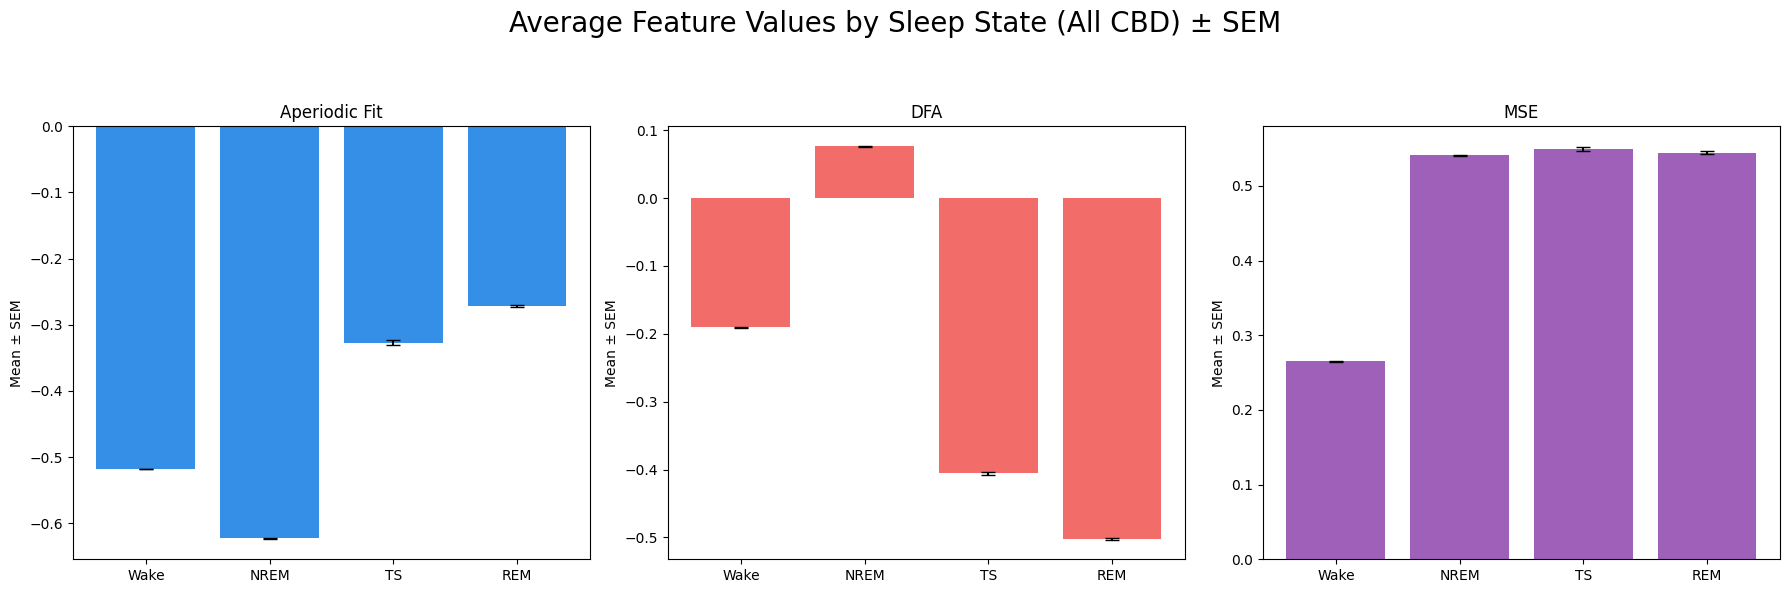

In [ ]:
state_order = ["Wake", "NREM", "TS", "REM"]
feature_colors = {
    "Aperiodic Fit": '#127be3',
    "DFA": '#f0544f',
    "MSE": '#8e44ad'
}

filtered_df = feature_table.dropna(subset=["Aperiodic Fit", "DFA", "MSE"])

# Group data
grouped = filtered_df.groupby("Sleep State")

# Compute mean and SEM
feature_means = grouped[["Aperiodic Fit", "DFA", "MSE"]].mean()
feature_sems = grouped[["Aperiodic Fit", "DFA", "MSE"]].sem()

valid_states = [s for s in state_order if s in feature_means.index]
feature_means = feature_means.loc[valid_states]
feature_sems = feature_sems.loc[valid_states]

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Average Feature Values by Sleep State (All CBD) ± SEM", fontsize=20)

for i, feature in enumerate(["Aperiodic Fit", "DFA", "MSE"]):
    axs[i].bar(
        feature_means.index,
        feature_means[feature],
        yerr=feature_sems[feature],
        color=feature_colors[feature],
        capsize=5,
        alpha=0.85
    )
    axs[i].set_title(feature)
    axs[i].set_ylabel("Mean ± SEM")
    #axs[i].grid(axis='y')

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig("all_feature_histogram_CBD.png")
plt.show()

In [ ]:
state_order = ["Wake", "NREM", "TS", "REM"]
feature_colors = {
    "Aperiodic Fit": '#127be3',
    "DFA": '#f0544f',
    "MSE": '#8e44ad'
}

# Output folder
output_dir = "D:/Projects/Donders Project/Outputs/Plots_CBD/Feature_Histograms"
os.makedirs(output_dir, exist_ok=True)

filtered_df = feature_table.dropna(subset=["Aperiodic Fit", "DFA", "MSE"])
grouped_rats = filtered_df.groupby(["RatID", "Condition"])

for (rat_id, condition), group_df in grouped_rats:
    group_df = group_df.copy()
    group_df = group_df[group_df["Sleep State"].isin(state_order)]

    # Compute per-state mean and SEM
    means = group_df.groupby("Sleep State")[["Aperiodic Fit", "DFA", "MSE"]].mean()
    sems = group_df.groupby("Sleep State")[["Aperiodic Fit", "DFA", "MSE"]].sem()

    valid_states = [s for s in state_order if s in means.index]
    means = means.loc[valid_states]
    sems = sems.loc[valid_states]

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Rat {rat_id} | Condition: {condition} | Feature Mean ± SEM", fontsize=20)

    for i, feature in enumerate(["Aperiodic Fit", "DFA", "MSE"]):
        axs[i].bar(
            means.index,
            means[feature],
            yerr=sems[feature],
            color=feature_colors[feature],
            capsize=5,
            alpha=0.85
        )
        axs[i].set_title(feature)
        axs[i].set_ylabel("Mean ± SEM")
        axs[i].set_xlabel("Sleep State")
        axs[i].set_ylim(auto=True)

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    fname = f"Rat{rat_id}_{condition}_feature_histogram.png"
    plt.savefig(os.path.join(output_dir, fname))
    plt.close()
    print(f"Saved: {fname}")

## Violin Plots

C:\Users\USER\AppData\Local\Temp\ipykernel_5448\2089136653.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\USER\AppData\Local\Temp\ipykernel_5448\2089136653.py:21: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(
C:\Users\USER\AppData\Local\Temp\ipykernel_5448\2089136653.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\USER\AppData\Local\Temp\ipykernel_5448\2089136653.py:21: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(
C:\Users\USER\AppData\Local\Temp\ipykernel_5

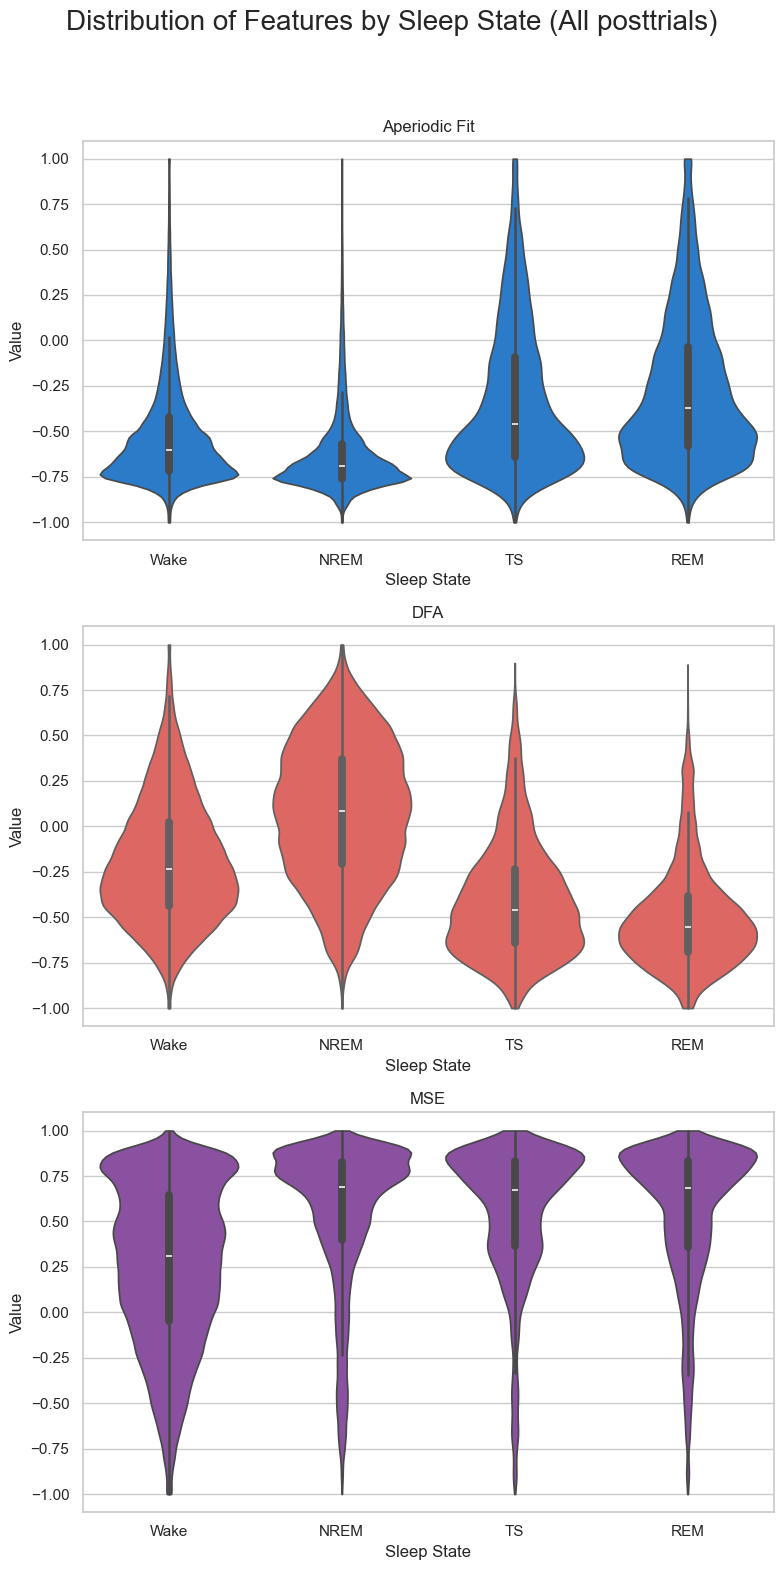

In [ ]:
sns.set(style="whitegrid")

state_order = ["Wake", "NREM", "TS", "REM"]
feature_colors = {
    "Aperiodic Fit": '#127be3',
    "DFA": '#f0544f',
    "MSE": '#8e44ad'
}

# Filtering missing values
filtered_df = feature_table.dropna(subset=["Aperiodic Fit", "DFA", "MSE"])

fig, axs = plt.subplots(3, 1, figsize=(8, 16), sharey=True)
fig.suptitle("Distribution of Features by Sleep State (All posttrials)", fontsize=20)

# Plot
for i, feature in enumerate(["Aperiodic Fit", "DFA", "MSE"]):
    sns.violinplot(
        ax=axs[i],
        x="Sleep State",
        y=feature,
        data=filtered_df,
        order=state_order,
        palette=[feature_colors[feature]],
        inner="box",
        cut=0
    )
    axs[i].set_title(feature)
    axs[i].set_xlabel("Sleep State")
    axs[i].set_ylabel("Value")


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("all_violinplots_CBD.png")
plt.show()

In [ ]:
sns.set(style="whitegrid")

state_order = ["Wake", "NREM", "TS", "REM"]
feature_colors = {
    "Aperiodic Fit": '#127be3',
    "DFA": '#f0544f',
    "MSE": '#8e44ad'
}

filtered_df = feature_table.dropna(subset=["Aperiodic Fit", "DFA", "MSE"])

# Create output directory
violin_output_dir = "D:/Projects/Donders Project/Outputs/Plots_CBD/Feature_Violinplots"
os.makedirs(violin_output_dir, exist_ok=True)

# Group by Rat × Condition
grouped = filtered_df.groupby(["RatID", "Condition"])

for (rat_id, condition), group_df in grouped:
    group_df = group_df.copy()
    group_df = group_df[group_df["Sleep State"].isin(state_order)]

    fig, axs = plt.subplots(3, 1, figsize=(8, 16), sharey=True)
    fig.suptitle(f"Rat {rat_id} | Condition: {condition} — Feature Distributions", fontsize=20)

    for i, feature in enumerate(["Aperiodic Fit", "DFA", "MSE"]):
        sns.violinplot(
            ax=axs[i],
            x="Sleep State",
            y=feature,
            data=group_df,
            order=state_order,
            palette=[feature_colors[feature]],
            inner="box",
            cut=0
        )
        axs[i].set_title(feature)
        axs[i].set_xlabel("Sleep State")
        axs[i].set_ylabel("Value")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fname = f"Rat{rat_id}_{condition}_violinplot.png"
    plt.savefig(os.path.join(violin_output_dir, fname))
    plt.close()
    print(f"Saved: {fname}")